In [1]:
using LinearAlgebra
using DifferentialEquations
using ForwardDiff
using Geodesy

In [ ]:
#GS Locations
wean_lla = LLA(40.4427217, -79.9479335, 17.0)
wean_ecef = ECEF(wean_lla, wgs84)
gs1_ecef = Array(wean_ecef)./1000.0
reynolds_lla = LLA(40.4499502, -79.915895, 17.0)
reynolds_ecef = ECEF(reynolds_lla, wgs84)
gs2_ecef = Array(reynolds_ecef)./1000.0
nrec_lla = LLA(40.4712452, -79.9661841, 16.6)
nrec_ecef = ECEF(nrec_lla, wgs84)
gs3_ecef = Array(nrec_ecef)./1000.0

In [ ]:
function ecef2eci(x_ecef,t)
    Ω = 2*pi/86164.0905 #rad/sec
    θ = Ω*t
    c = cos(Ω*t)
    s = sin(Ω*t)
    
    x_eci = [c -s 0; s c 0; 0 0 1]*x_ecef
end

In [2]:
function dynamics!(xdot,x,params,t)
    μ = 398600.44 #km^3/s^2
    r = x[1:3]
    v = x[4:6]
    
    a = -(μ/(norm(r)^3)).*r
    
    xdot .= [v; a]
end

dynamics! (generic function with 1 method)

In [80]:
function g(x,t)
    gs1_eci = ecef2eci(gs1_ecef,t)
    gs2_eci = ecef2eci(gs2_ecef,t)
    gs3_eci = ecef2eci(gs3_ecef,t)

    r1 = norm(x[1:3]-gs1_eci)
    r2 = norm(x[1:3]-gs2_eci)
    r3 = norm(x[1:3]-gs3_eci)
        
    y = [r2-r1; r3-r1; r3-r2]
end

g (generic function with 1 method)

In [22]:
#Initial Conditions (polar orbit passing directly over GS at t=0)
μ = 398600.44 #km^3/s^2
Re = 6371.0 #km
r0 = (Re+550.0)*(gs1_ecef/norm(gs1_ecef))
v0 = cross(r0, cross(r0,[0;0;1]))
v0 = sqrt(μ/norm(r0))*v0/norm(v0)
x0 = [r0; v0]

6-element Array{Float64,1}:
   921.9556818709577
 -5201.028272470356
  4472.084930949979
     0.8559101404321281
    -4.82844558216481
    -5.791927837238977

In [37]:
#Integrate backward for 10 minutes
tspan = (0.0,10.0*60)
prob1 = ODEProblem(dynamics!,[r0; -v0],tspan)
soln1 = solve(prob1, Tsit5(), reltol=1e-9, abstol=1e-9)

#Integrate forward for 10 minutes
tspan = (0.0,10.0*60)
prob2 = ODEProblem(dynamics!,[r0; v0],tspan)
soln2 = solve(prob2, Tsit5(), reltol=1e-9, abstol=1e-9)

#Sample satellite positions every 10 seconds
thist = Array(range(-600.0, 600.0, step=10.0))
xhist = zeros(3,length(thist))
for k = 1:length(thist)
    if thist[k] < 0.0
        xhist[:,k] .= soln1(-thist[k])[1:3]
    else
        xhist[:,k] .= soln2(thist[k])[1:3]
    end
end

In [67]:
#Calculate elevation
ele = zeros(length(thist))
for k = 1:length(thist)
    gs1_eci = ecef2eci(gs1_ecef,thist[k])
    y = (xhist[:,k]-gs1_eci)
    ele[k] = pi/2-acos((y/norm(y))'*(gs1_eci/norm(gs1_eci)))
end

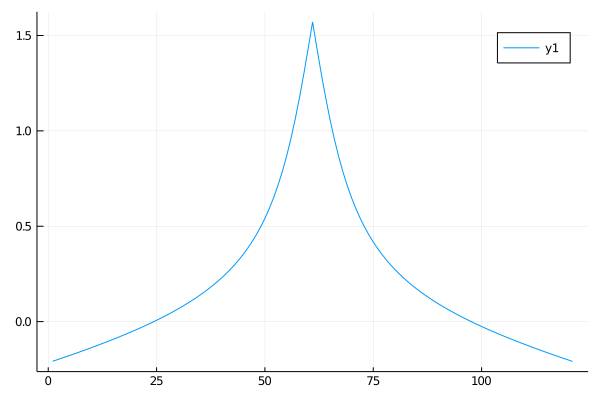

In [68]:
plot(ele)

In [77]:
#Generate noise-free Measurements
yhist = zeros(3,length(thist))
for k = 1:length(thist)
        gs1_eci = ecef2eci(gs1_ecef,thist[k])
        gs2_eci = ecef2eci(gs2_ecef,thist[k])
        gs3_eci = ecef2eci(gs3_ecef,thist[k])
        
        r1 = norm(xhist[:,k]-gs1_eci)
        r2 = norm(xhist[:,k]-gs2_eci)
        r3 = norm(xhist[:,k]-gs3_eci)
        
        yhist[:,k] .= [r2-r1; r3-r1; r3-r2]
end

In [78]:
yhist

3×121 Array{Float64,2}:
 -0.825284  -0.828485  -0.831642  -0.834752  …  0.975582  0.974605  0.97357
 -3.07832   -3.08197   -3.08549   -3.08887      2.99107   2.98597   2.98075
 -2.25303   -2.25349   -2.25385   -2.25412      2.01549   2.01137   2.00718